In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
netflix = pd.read_csv('/Users/yenhann/Documents/MIT/15.572 Analytics Lab/Datasets/complete_manually_cleaned_data.csv')
ratings = pd.read_csv('/Users/yenhann/Documents/MIT/15.572 Analytics Lab/Datasets/title.ratings.tsv', sep='\t')

df = netflix.merge(ratings, how='left', on='tconst')

#My Wonderful Life Manually added data

df.loc[df['title']=='my wonderful life', 'averageRating'] = 5.9
df.loc[df['title']=='my wonderful life', 'numVotes'] = 714
df.loc[df['title']=='my wonderful life', 'titleType'] = 'movie'
df.loc[df['title']=='my wonderful life', 'runtimeMinutes'] = 99
df.loc[df['title']=='my wonderful life', 'isAdult'] = 0
df.loc[df['title']=='my wonderful life', 'genres'] = 'Comedy,Drama,Romance'

In [4]:
df['is_top10'] = df['is_top10'].astype(int)
df.replace('\\N', np.nan, inplace=True)

In [5]:
movies, tv_shows = df[df['is_tv_show']==False], df[df['is_tv_show']==True]

# Movies

## Data Preparation

In [6]:
# drop columns that are not needed
movies = movies.drop(['tconst', 'release_date','combined_title', 'title', 'season', 'is_tv_show', 'isAdult'], axis = 1)

In [7]:
movies.columns
movies

,release_year,is_top10,averageRating_x,numVotes_x,titleType,runtimeMinutes,genres,averageRating_y,numVotes_y,averageRating,numVotes
2,2020,0,6.1,856.0,movie,100,"Comedy,Family",6.1,856.0,NaN,NaN
4,2021,1,5.8,1531.0,movie,102,"Comedy,Romance",5.8,1531.0,NaN,NaN
5,2022,1,6.9,1928.0,movie,92,Documentary,6.9,1928.0,NaN,NaN
7,2021,1,6.3,932.0,movie,104,"Crime,Documentary",6.3,932.0,NaN,NaN
8,2022,0,5.2,621.0,movie,91,"Comedy,Drama,Family",5.2,621.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2216,2022,0,6.5,46.0,tvSpecial,59,"Comedy,Documentary",6.5,46.0,NaN,NaN
2218,2021,1,6.7,925.0,movie,102,"Biography,Drama,Sport",6.7,925.0,NaN,NaN
2220,2020,0,6.3,2648.0,movie,97,"Documentary,Music",6.3,2648.0,NaN,NaN
2223,2021,1,7.5,103877.0,movie,120,"Biography,Drama,Musical",7.5,103877.0,NaN,NaN


In [8]:
movies = movies[['release_year','is_top10', 'averageRating_x', 'numVotes_x','titleType','runtimeMinutes','genres']]

In [9]:
movies = movies.rename(columns = {'averageRating_x': 'averageRating', 'numVotes_x': 'numVotes'})

In [10]:
movies = movies.reset_index(drop = True)

In [11]:
movies.isna().sum()

release_year      0
is_top10          0
averageRating     4
numVotes          4
titleType         0
runtimeMinutes    5
genres            0
dtype: int64

In [12]:
movies.titleType.value_counts()

movie        742
tvSpecial    130
short         46
Name: titleType, dtype: int64

### Impute averageRating, numVotes, and runtimeMinutes with Mean

In [13]:
from sklearn.model_selection import train_test_split
movies_train, movies_test = train_test_split(movies, test_size=0.3, random_state=100)

# Training set
movies_train_X = movies_train.drop(['is_top10'], axis = 1)
movies_train_Y = movies_train['is_top10']

# Test set
movies_test_X = movies_test.drop(['is_top10'], axis = 1)
movies_test_Y = movies_test['is_top10']

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),                # One hot encode title types
    ("imputer", SimpleImputer(strategy='mean'), ['averageRating', 'numVotes', 'runtimeMinutes']),   # Impute missing ratings, votes, and runtime with the average
    ("bagofw", CountVectorizer(), 'genres')                                                         # Splits genres into bag of words and encode them
    ],
    remainder='passthrough')

### Model 1 : Decision Tree

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn import tree
import sklearn.preprocessing
import sklearn.linear_model

# make sklearn pipeline with transform, normalization, and model (CART)
pipeTree = Pipeline(
    steps=[
        ('transformer', transformer),                                                       # Transform dataset                
        # ('normalizer', sklearn.preprocessing.Normalizer()),                                 # Normalise features
        # ('standardizer', sklearn.preprocessing.StandardScaler(with_mean=False)),            # Rescale dataset
        ('decisiontree', sklearn.tree.DecisionTreeClassifier())                             # Build Decision Tree model
    ]
)    

In [38]:
# use grid search to cross validate tree model - 5-fold cross validation
from sklearn.model_selection import GridSearchCV

gsTree = GridSearchCV(
    pipeTree,
    param_grid={
        'decisiontree__max_depth': [5, 6, 7, 8, 9, 10],
        'decisiontree__min_samples_leaf': [1, 5, 10, 15, 20],
        'decisiontree__criterion': ['gini', 'entropy', 'log_loss'],
    },
    scoring={"AUC": "roc_auc", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [39]:
gsTree.fit(movies_train_X, movies_train_Y)

/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 937, in fit
    s

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         SimpleImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
            

In [40]:
# retrieve the best parameters and estimators returned by the grid search cross validation step
gsTree.best_params_
gsTree.best_score_
best_decisiontree = gsTree.best_estimator_

Accuracy:  0.7318840579710145
AUC:  0.7759191176470588


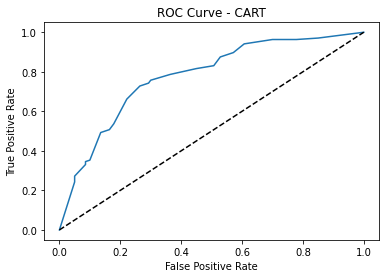

In [41]:
best_decisiontree.fit(movies_train_X, movies_train_Y)

from sklearn.metrics import roc_auc_score, accuracy_score

y_prob_pred = best_decisiontree.predict_proba(movies_test_X)[:,1]
y_pred = best_decisiontree.predict(movies_test_X)

print("Accuracy: ", accuracy_score(movies_test_Y, y_pred))
print("AUC: ", roc_auc_score(movies_test_Y, y_prob_pred))

#plot auc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(movies_test_Y, y_prob_pred)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CART')
plt.show()

AUCPR:  0.7638057365680034


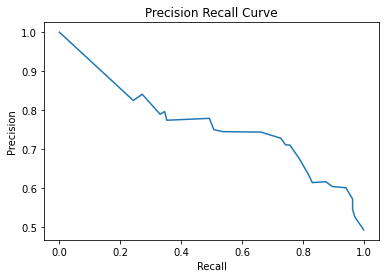

F1 Score:  0.7279411764705882


In [42]:
#calculate precision recall
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(movies_test_Y, y_prob_pred)

#auc of precision recall curve
from sklearn.metrics import auc

print("AUCPR: ", auc(recall, precision))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

#calculate f1 score
from sklearn.metrics import f1_score

print("F1 Score: ", f1_score(movies_test_Y, y_pred))

### Model 2 : Random Forest

In [ ]:
# make sklearn pipeline with transform, normalization, and model (RF)
from sklean.ensemble import RandomForestClassifier

pipeRF = Pipeline(
    steps=[
        ('transformer', transformer),                                                       # Transform dataset                
        ('normalizer', sklearn.preprocessing.Normalizer()),                                 # Normalise features
        ('standardizer', sklearn.preprocessing.StandardScaler(with_mean=False)),            # Rescale dataset
        ('decisiontree', sklearn.tree.DecisionTreeClassifier())                             # Build Decision Tree model
    ]
)    

## TV Shows

### Data Preparation

In [23]:
tv_shows = tv_shows[['release_year','is_top10','season','averageRating_x', 'numVotes_x','titleType','runtimeMinutes','genres']]
tv_shows

,release_year,is_top10,season,averageRating_x,numVotes_x,titleType,runtimeMinutes,genres
0,2020,0,1.0,6.8,4892.0,tvSeries,36,Comedy
1,2020,0,1.0,6.4,1091.0,tvSeries,NaN,Documentary
3,2020,0,1.0,5.8,4153.0,tvSeries,NaN,Reality-TV
6,2020,1,4.0,7.5,289852.0,tvSeries,60,"Drama,Mystery,Thriller"
11,2020,1,4.0,7.3,25736.0,tvSeries,49,"Action,Drama,Sci-Fi"
...,...,...,...,...,...,...,...,...
2217,2021,1,1.0,5.7,1462.0,tvSeries,35,"Comedy,Drama,Family"
2219,2021,0,1.0,5.7,1329.0,tvSeries,27,"Action,Comedy,Drama"
2221,2022,1,1.0,8.0,9043.0,tvMiniSeries,90,"Documentary,Music"
2222,2020,0,1.0,2.5,3352.0,tvSeries,30,"Documentary,Reality-TV"


In [24]:
tv_shows.isna().sum()

release_year         0
is_top10             0
season               0
averageRating_x      3
numVotes_x           3
titleType            0
runtimeMinutes     266
genres               0
dtype: int64